In [1]:
import pandas as pd
from datetime import datetime, timedelta

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Define date range
start_date = datetime(2023, 1, 1)
end_date = datetime(2025, 12, 31)

# Generate date range with daily frequency
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate random sales data
# Using a combination of base sales + trend + seasonality + random noise
n_days = len(date_range)

# Base sales around 1000 units
base_sales = 1000

# Add trend component (slight upward trend over time)
trend = np.linspace(0, 200, n_days)

# Add seasonal component (yearly cycle)
seasonal = 150 * np.sin(2 * np.pi * np.arange(n_days) / 365.25)

# Add weekly pattern (higher sales on weekends)
day_of_week = pd.Series(date_range).dt.dayofweek
weekly_pattern = np.where(day_of_week.isin([5, 6]), 100, 0)  # Weekend boost

# Add random noise
noise = np.random.normal(0, 50, n_days)

# Combine all components
sales = base_sales + trend + seasonal + weekly_pattern + noise

# Ensure sales are positive
sales = np.maximum(sales, 0)

# Round to nearest integer
sales = np.round(sales).astype(int)

# Create DataFrame
df = pd.DataFrame({
    'date': date_range,
    'sales': sales
})

# Display first and last few rows
print("Dataset created successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst 10 rows:")
print(df.head(10))
print(f"\nLast 10 rows:")
print(df.tail(10))

# Basic statistics
print(f"\nBasic Statistics:")
print(df['sales'].describe())

# Save to CSV file
csv_filename = 'sales_data_2023_2025.csv'
df.to_csv(csv_filename, index=False)
print(f"\nDataset saved to '{csv_filename}'")





Dataset created successfully!

Dataset shape: (1096, 2)
Date range: 2023-01-01 00:00:00 to 2025-12-31 00:00:00

First 10 rows:
        date  sales
0 2023-01-01   1125
1 2023-01-02    996
2 2023-01-03   1038
3 2023-01-04   1084
4 2023-01-05    999
5 2023-01-06   1002
6 2023-01-07   1196
7 2023-01-08   1158
8 2023-01-09    999
9 2023-01-10   1052

Last 10 rows:
           date  sales
1086 2025-12-22   1225
1087 2025-12-23   1188
1088 2025-12-24   1166
1089 2025-12-25   1172
1090 2025-12-26   1181
1091 2025-12-27   1285
1092 2025-12-28   1326
1093 2025-12-29   1195
1094 2025-12-30   1232
1095 2025-12-31   1194

Basic Statistics:
count    1096.000000
mean     1130.197080
std       127.268089
min       739.000000
25%      1039.750000
50%      1132.000000
75%      1219.250000
max      1514.000000
Name: sales, dtype: float64

Dataset saved to 'sales_data_2023_2025.csv'


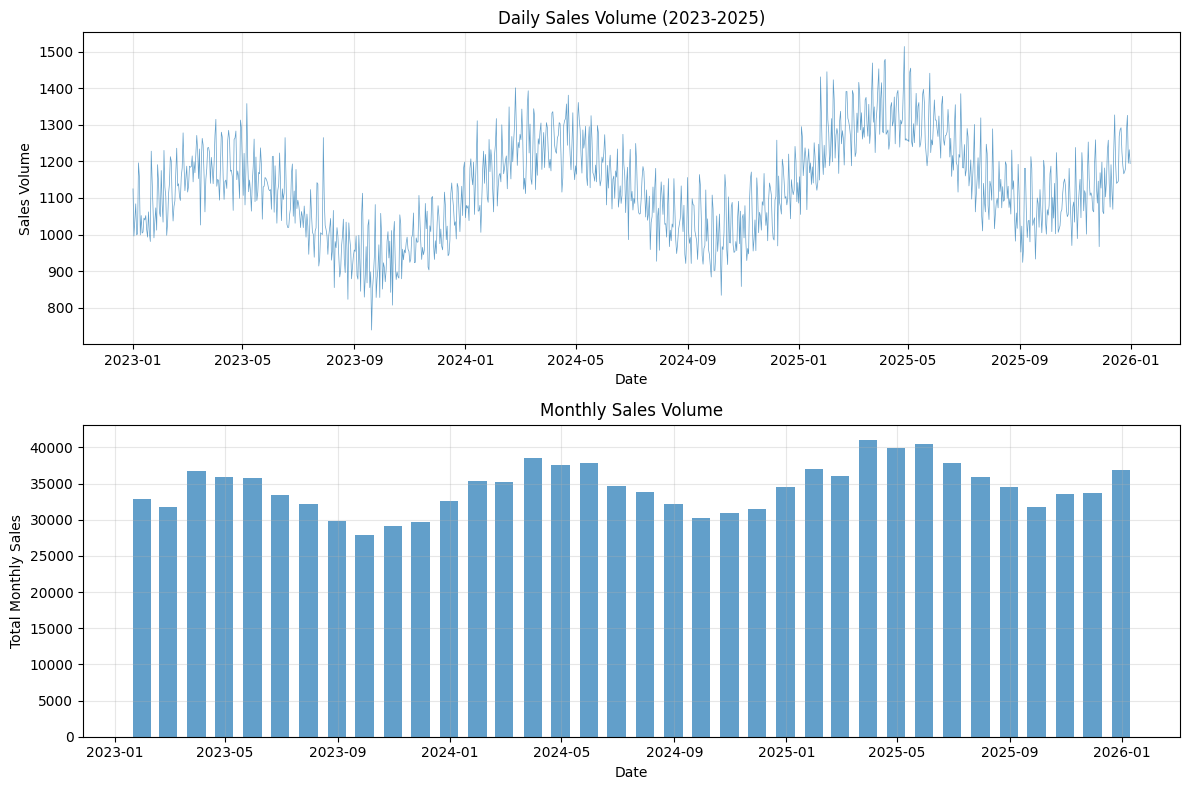


Visualization saved to 'sales_visualization.png'


In [26]:
# Create a simple visualization
try:
    import matplotlib.pyplot as plt
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Full time series
    axes[0].plot(df['date'], df['sales'], linewidth=0.5, alpha=0.7)
    axes[0].set_title('Daily Sales Volume (2023-2025)')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Sales Volume')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Monthly aggregated sales
    df_monthly = df.set_index('date').resample('ME')['sales'].sum().reset_index()
    axes[1].bar(df_monthly['date'], df_monthly['sales'], width=20, alpha=0.7)
    axes[1].set_title('Monthly Sales Volume')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Total Monthly Sales')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('sales_visualization.png', dpi=100)
    plt.show()
    print("\nVisualization saved to 'sales_visualization.png'")
    
except ImportError:
    print("\nNote: Install matplotlib for visualization (pip install matplotlib)")

In [5]:
def prepare_prophet_data(data, date_col, value_col, freq="D"):
    """
    Prepare data for Prophet training.

    Args:
        data: DataFrame with time series data
        date_col: Name of date column
        value_col: Name of value column
        freq: Frequency of the time series
    """

    # Prophet requires columns named 'ds' (datestamp) and 'y' (value)
    prophet_df = data[[date_col, value_col]].copy()
    prophet_df.columns = ["ds", "y"]

    # Ensure ds is datetime
    prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])

    # Sort by date
    prophet_df = prophet_df.sort_values("ds").reset_index(drop=True)

    # Handle missing dates if needed
    if freq:
        full_date_range = pd.date_range(
            start=prophet_df["ds"].min(), end=prophet_df["ds"].max(), freq=freq
        )

        # Reindex to fill missing dates
        prophet_df = prophet_df.set_index("ds").reindex(full_date_range).reset_index()
        prophet_df.columns = ["ds", "y"]

        # Log data quality metrics
        missing_dates = prophet_df["y"].isna().sum()
        print(f"Missing dates filled: {missing_dates}")

    return prophet_df

In [7]:
raw_data =  pd.read_csv("sales_data_2023_2025.csv")
df_prepared = prepare_prophet_data(raw_data, 'date', 'sales', freq='D')
df_prepared.head()

Missing dates filled: 0


,ds,y
0,2023-01-01,1125
1,2023-01-02,996
2,2023-01-03,1038
3,2023-01-04,1084
4,2023-01-05,999


In [8]:
import mlflow
import mlflow.prophet
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from dotenv import load_dotenv
import datetime
# Load environment variables from .env file
load_dotenv()


experiment_name = "/Users/j.huertas@closerstillmedia.com/prophet"
try:
    mlflow.create_experiment(experiment_name)
except:
    print("experiment exists")
mlflow.set_experiment(experiment_name)

experiment exists


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3039328626124250', creation_time=1755624146266, experiment_id='3039328626124250', last_update_time=1755624164283, lifecycle_stage='active', name='/Users/j.huertas@closerstillmedia.com/prophet', tags={'mlflow.databricks.filesystem.experiment_permissions_check': 'test',
 'mlflow.experiment.sourceName': '/Users/j.huertas@closerstillmedia.com/prophet',
 'mlflow.experimentKind': 'custom_model_development',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'b.relf@closerstillmedia.com',
 'mlflow.ownerId': '7931383772120950'}>

# Seasonality and Trend Configuration

In [10]:
def advanced_prophet_configuration():
    """Demonstrate advanced Prophet configuration options."""

    with mlflow.start_run(run_name="Advanced Prophet Configuration"):
        # Create Prophet model with advanced settings
        model = Prophet(
            # Trend configuration
            growth="logistic",  # or 'linear'
            changepoints=None,  # Let Prophet auto-detect, or specify dates
            n_changepoints=25,  # Number of potential changepoints
            changepoint_range=0.8,  # Proportion of history for changepoints
            changepoint_prior_scale=0.05,  # Flexibility of trend changes
            # Seasonality configuration
            yearly_seasonality="auto",  # or True/False/number
            weekly_seasonality="auto",
            daily_seasonality="auto",
            seasonality_mode="additive",  # or 'multiplicative'
            seasonality_prior_scale=10,
            # Holiday configuration
            holidays_prior_scale=10,
            # Uncertainty configuration
            interval_width=0.80,  # Width of uncertainty intervals
            uncertainty_samples=1000,  # Monte Carlo samples for uncertainty
            # Stan configuration
            mcmc_samples=0,  # Use MAP instead of MCMC
            stan_backend="CMDSTANPY",  # Stan backend
        )

        # For logistic growth, need to specify capacity
        if model.growth == "logistic":
            df_prepared["cap"] = df_prepared["y"].max() * 1.2  # Set capacity 20% above max observed
            df_prepared["floor"] = 0  # Optional floor

        # Fit the model
        model.fit(df_prepared)

        # Log configuration parameters
        config_params = {
            "growth": model.growth,
            "n_changepoints": model.n_changepoints,
            "changepoint_range": model.changepoint_range,
            "seasonality_mode": model.seasonality_mode,
            "interval_width": model.interval_width,
        }
        mlflow.log_params(config_params)

        return model


# Usage
advanced_model = advanced_prophet_configuration()

19:14:37 - cmdstanpy - INFO - Chain [1] start processing
19:14:38 - cmdstanpy - INFO - Chain [1] done processing


🏃 View run Advanced Prophet Configuration at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/47e973719d7140a8bb8400a2df5d2ef6
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


# Custom Seasonalities and Events

In [12]:
def add_custom_components(model, df):
    """Add custom seasonalities and regressors to Prophet model."""

    with mlflow.start_run(run_name="Custom Prophet Components"):
        # Add custom seasonalities
        model.add_seasonality(
            name="monthly",
            period=30.5,  # Monthly seasonality
            fourier_order=5,  # Number of Fourier terms
        )

        model.add_seasonality(
            name="quarterly", period=91.25, fourier_order=8  # Quarterly seasonality
        )

        # Add conditional seasonalities (e.g., different patterns for weekdays/weekends)
        def is_weekend(ds):
            date = pd.to_datetime(ds)
            return date.weekday() >= 5

        df["weekend"] = df["ds"].apply(is_weekend)

        model.add_seasonality(
            name="weekend_seasonality",
            period=7,
            fourier_order=3,
            condition_name="weekend",
        )

        # Add external regressors
        # Example: Add economic indicator or marketing spend
        np.random.seed(42)
        df["marketing_spend"] = np.random.normal(1000, 200, len(df))
        df["economic_indicator"] = np.random.normal(50, 10, len(df))

        model.add_regressor("marketing_spend", prior_scale=0.5)
        model.add_regressor("economic_indicator", prior_scale=0.3)

        # Fit model with custom components
        model.fit(df)

        # Log custom component information
        mlflow.log_params(
            {
                "custom_seasonalities": ["monthly", "quarterly", "weekend_seasonality"],
                "external_regressors": ["marketing_spend", "economic_indicator"],
                  
                "total_components": len(model.extra_regressors),
            }
        )

        return model, df

# "total_components": len(model.extra_seasonalities)
# Usage
model_with_custom = Prophet()
model_with_custom, enhanced_df = add_custom_components(model_with_custom, df_prepared.copy())

19:20:24 - cmdstanpy - INFO - Chain [1] start processing
19:20:28 - cmdstanpy - INFO - Chain [1] done processing


🏃 View run Custom Prophet Components at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/f464ef3e3c3a402b80d4279deeb00ba3
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


In [22]:
preds= model_with_custom.predict(enhanced_df)

In [23]:
preds

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-01,1027.295934,1816.8,1124.508543,1125.338003,1027.295934,1027.295934,97.627353,97.627353,97.627353,...,63.733430,63.733430,63.733430,0.486181,0.486181,0.486181,0.0,0.0,0.0,1124.923287
1,2023-01-02,1027.474796,1816.8,995.539944,996.372207,1027.474796,1027.474796,-31.503423,-31.503423,-31.503423,...,-25.466581,-25.466581,-25.466581,3.141422,3.141422,3.141422,0.0,0.0,0.0,995.971373
2,2023-01-03,1027.653658,1816.8,1037.555618,1038.365630,1027.653658,1027.653658,10.305345,10.305345,10.305345,...,-25.524051,-25.524051,-25.524051,5.792728,5.792728,5.792728,0.0,0.0,0.0,1037.959004
3,2023-01-04,1027.832520,1816.8,1084.050751,1084.882634,1027.832520,1027.832520,56.632986,56.632986,56.632986,...,-25.534144,-25.534144,-25.534144,8.437051,8.437051,8.437051,0.0,0.0,0.0,1084.465507
4,2023-01-05,1028.011383,1816.8,999.025955,999.826251,1028.011383,1028.011383,-28.579172,-28.579172,-28.579172,...,-25.444284,-25.444284,-25.444284,11.071415,11.071415,11.071415,0.0,0.0,0.0,999.432211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2025-12-27,1226.448385,1816.8,1284.829494,1285.630414,1226.448385,1226.448385,58.763614,58.763614,58.763614,...,63.747725,63.747725,63.747725,-12.087006,-12.087006,-12.087006,0.0,0.0,0.0,1285.211999
1092,2025-12-28,1226.631542,1816.8,1325.739684,1326.519709,1226.631542,1226.631542,99.512159,99.512159,99.512159,...,63.733430,63.733430,63.733430,-9.454050,-9.454050,-9.454050,0.0,0.0,0.0,1326.143701
1093,2025-12-29,1226.814699,1816.8,1194.701552,1195.531636,1226.814699,1226.814699,-31.690699,-31.690699,-31.690699,...,-25.466581,-25.466581,-25.466581,-6.811046,-6.811046,-6.811046,0.0,0.0,0.0,1195.124000
1094,2025-12-30,1226.997856,1816.8,1231.433066,1232.260538,1226.997856,1226.997856,4.853458,4.853458,4.853458,...,-25.524051,-25.524051,-25.524051,-4.160727,-4.160727,-4.160727,0.0,0.0,0.0,1231.851314


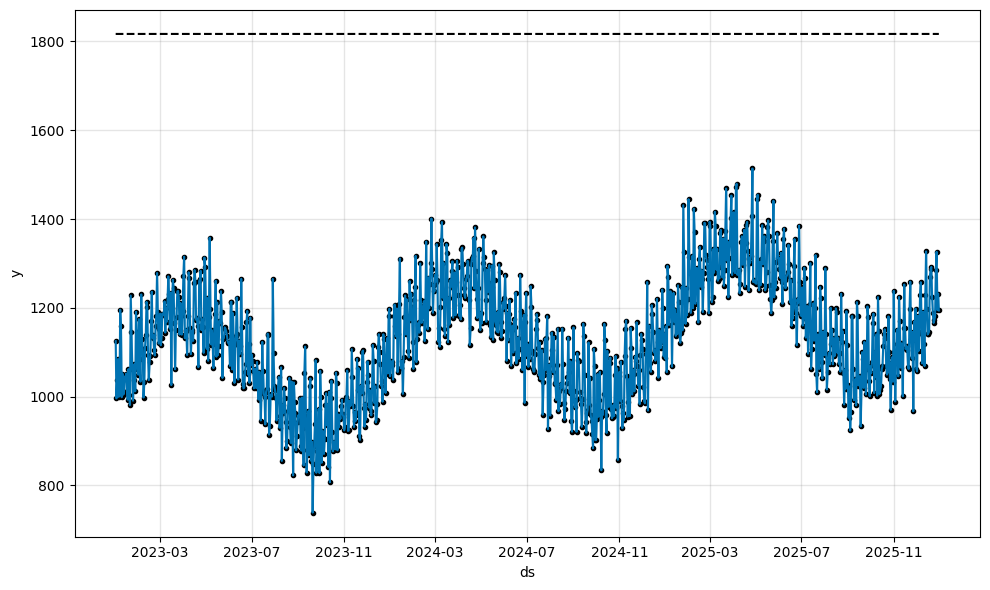

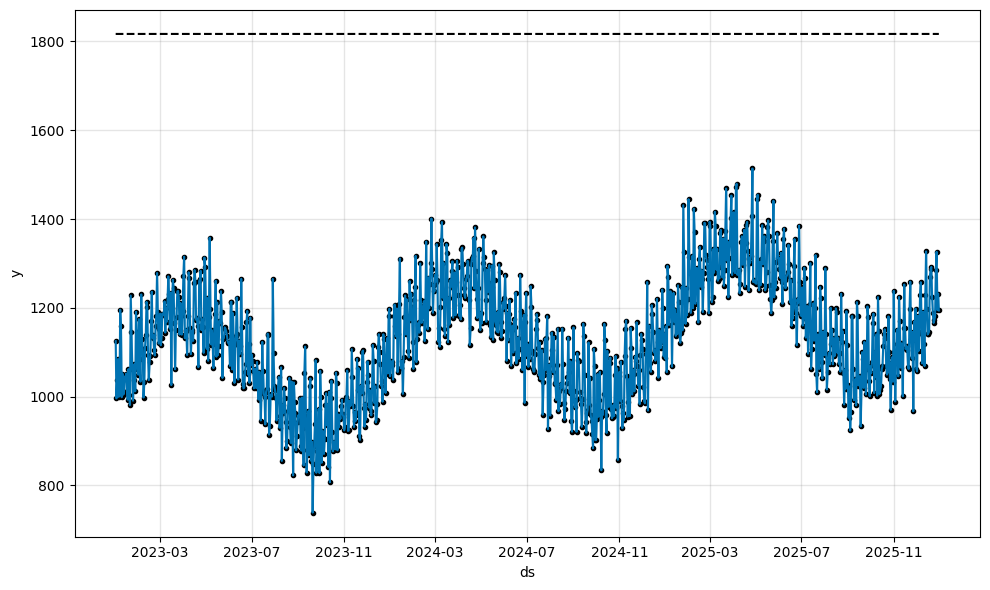

In [24]:
model_with_custom.plot(preds)

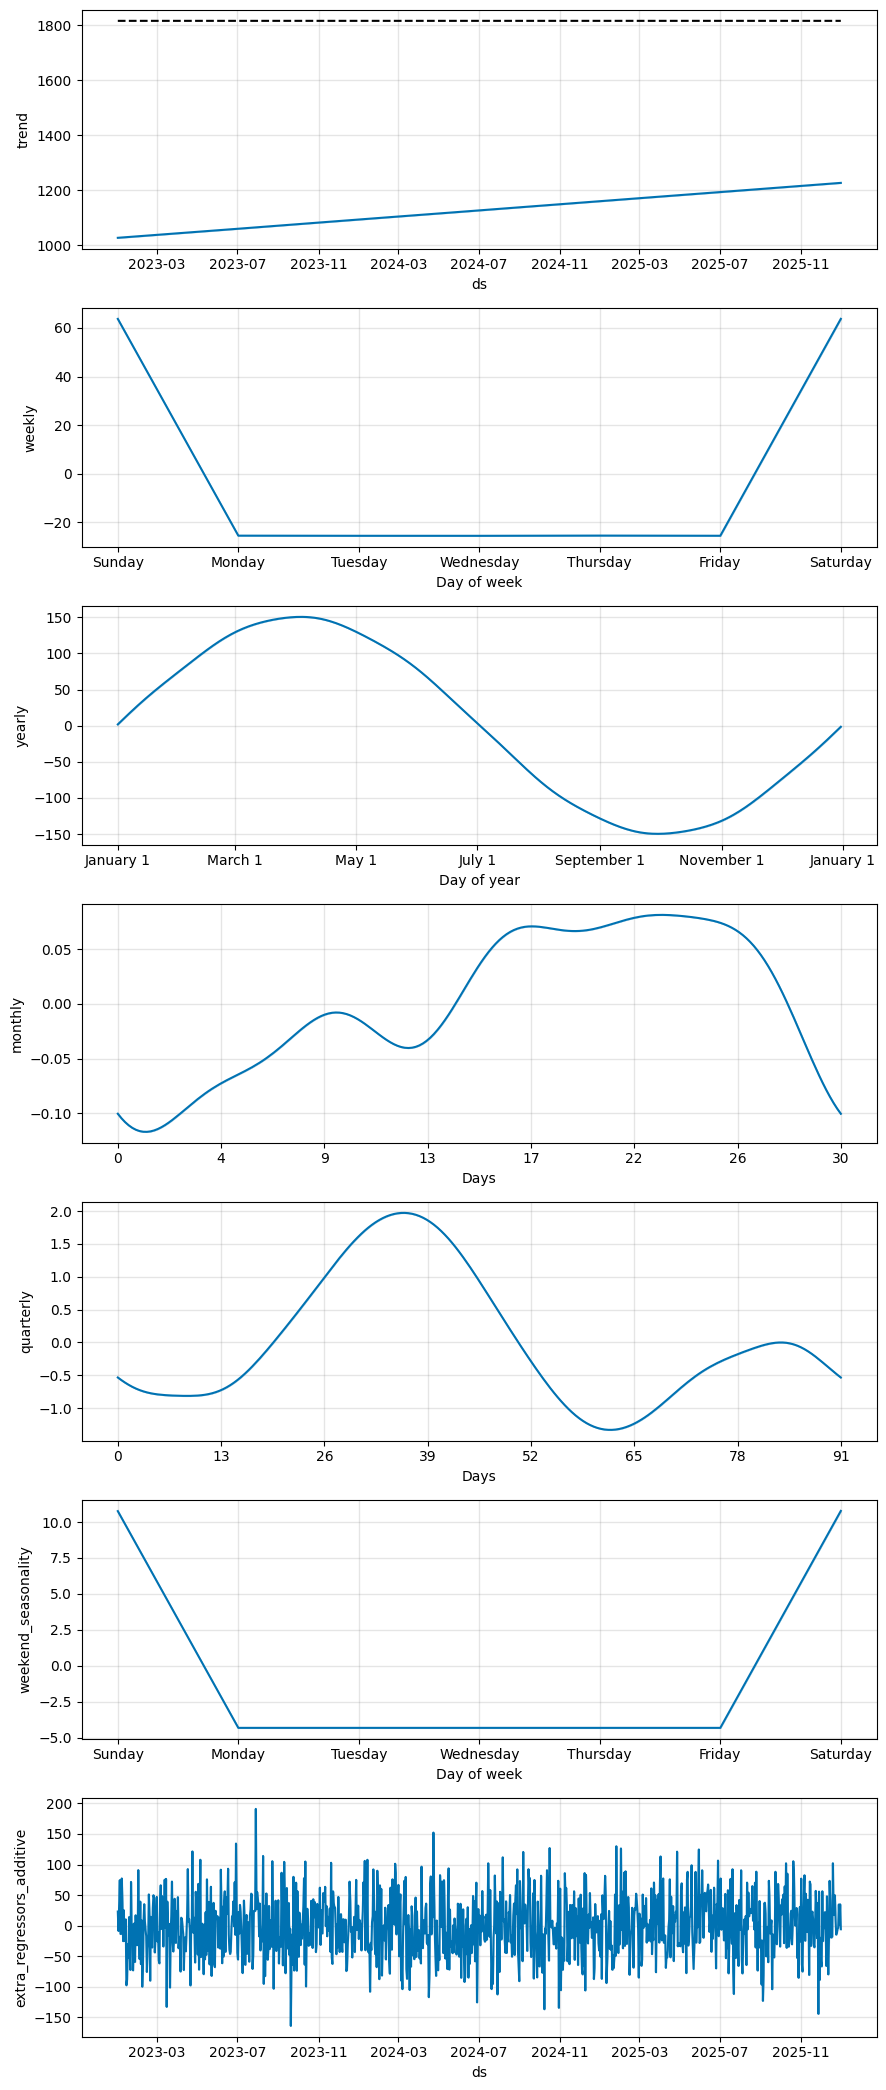

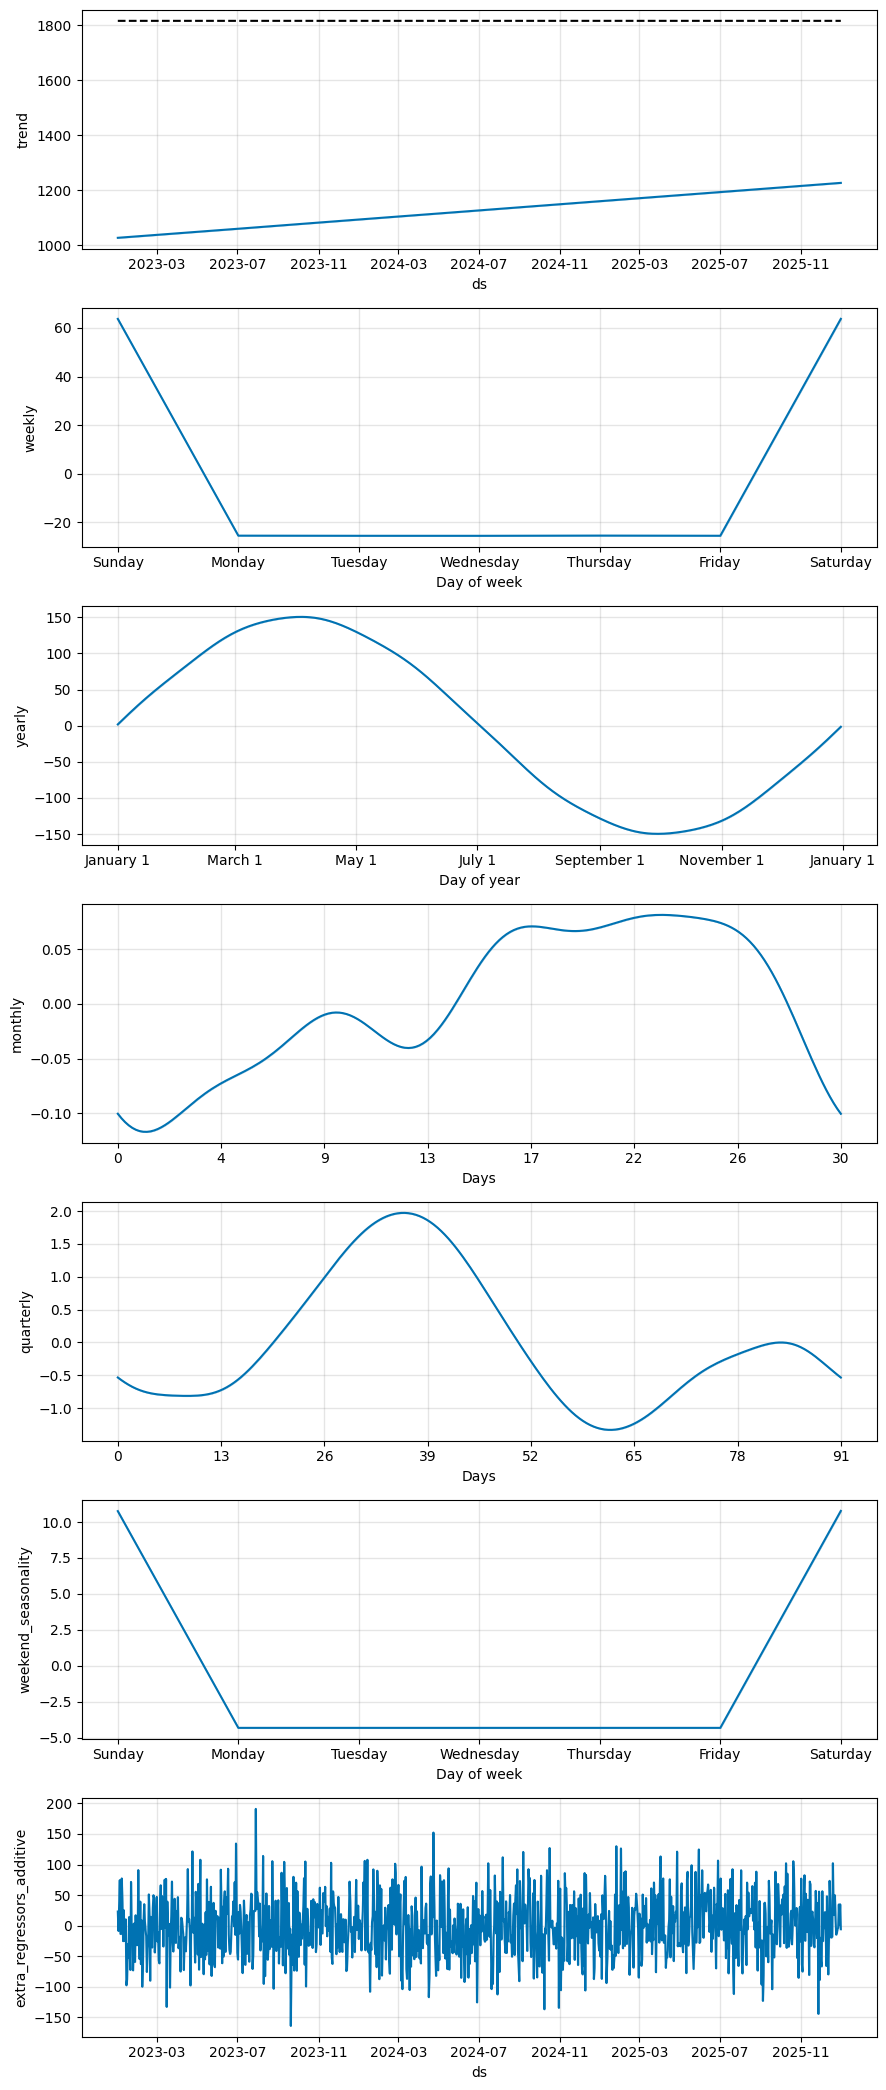

In [25]:
model_with_custom.plot_components(preds)